In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aman2000jaiswal/agriculture-crop-images")

print("Path to dataset files:", path)

100%|██████████| 59.7M/59.7M [00:00<00:00, 80.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aman2000jaiswal/agriculture-crop-images/versions/12


In [ ]:
!mv /root/.cache/kagglehub/datasets/aman2000jaiswal/agriculture-crop-images/versions/12 .

In [ ]:
!unzip ./kag2

Archive:  ./kag2.zip
   creating: kag2/
   creating: kag2/jute/
  inflating: kag2/jute/image (1).jpeg  
  inflating: kag2/jute/image (1).jpg  
  inflating: kag2/jute/image (10).jpg  
  inflating: kag2/jute/image (11).jpg  
  inflating: kag2/jute/image (12).jpg  
  inflating: kag2/jute/image (13).jpg  
  inflating: kag2/jute/image (14).jpg  
  inflating: kag2/jute/image (15).jpg  
  inflating: kag2/jute/image (16).jpg  
  inflating: kag2/jute/image (17).jpg  
  inflating: kag2/jute/image (18).jpg  
  inflating: kag2/jute/image (2).jpeg  
  inflating: kag2/jute/image (2).jpg  
  inflating: kag2/jute/image (20).jpg  
  inflating: kag2/jute/image (21).jpg  
  inflating: kag2/jute/image (3).jpeg  
  inflating: kag2/jute/image (4).jpeg  
  inflating: kag2/jute/image (4).jpg  
  inflating: kag2/jute/image (5).jpeg  
  inflating: kag2/jute/image (5).jpg  
  inflating: kag2/jute/image (7).jpg  
  inflating: kag2/jute/image (8).jpg  
  inflating: kag2/jute/image (9).jpg  
  inflating: kag2/jute/

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


dataset_path = 'kag2'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size,val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


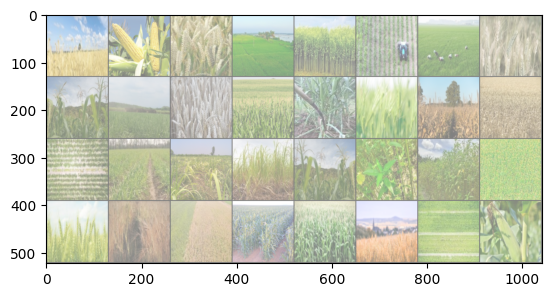

tensor([4, 1, 4, 2, 0, 3, 2, 4, 1, 3, 4, 1, 3, 4, 1, 4, 3, 3, 3, 3, 1, 0, 0, 1,
        4, 4, 1, 1, 1, 4, 3, 1])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Load a batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(labels)


In [ ]:
class_to_idx = dataset.class_to_idx

# Invert the dictionary to get index-to-class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Example: Get the class name for a specific label
label = 29  # Replace with the label you want to decode
real_value = idx_to_class[label]
print(f"The real value for label {label} is '{real_value}'")

KeyError: 29

In [ ]:
import torch
import torch.nn as nn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class image_model(nn.Module):
  def __init__(self):
    super(image_model,self).__init__()
    self.conv1 = nn.Conv2d(3,20,kernel_size=5)
    self.conv2 = nn.Conv2d(20,64,kernel_size=5)
    self.pool = nn.MaxPool2d(2,2)
    self.l1 = nn.Linear(64*29*29,128)
    self.l2 = nn.Linear(128,50)
    self.l3 = nn.Linear(50,30)
    self.relu = nn.ReLU()

  def forward(self,x):
    out = self.conv1(x)
    out = self.relu(out)
    out = self.pool(out)
    out = self.conv2(out)
    out = self.relu(out)
    out = self.pool(out)
    out = out.view(-1,64*29*29)
    out = self.l1(out)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    return out

model = image_model().to(device)

In [ ]:
class fullyconnectednetwork(nn.Module):
  def __init__(self,input_size,output_size):
    super(fullyconnectednetwork,self).__init__()
    self.l1 = nn.Linear(input_size,128)
    self.l2 = nn.Linear(128,64)
    self.l3 = nn.Linear(64,output_size)
    self.relu = nn.ReLU()

  def forward(self,x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    return out


In [ ]:
import torchvision

model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = fullyconnectednetwork(model.fc.in_features,5)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from sklearn.metrics import classification_report

lossf = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epoch = 2
for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = lossf(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    test_loss = 0
    classi_labels = []
    classi_preds = []
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = lossf(outputs, labels)
        classi_labels.extend(labels.cpu().numpy())
        classi_preds.extend(torch.argmax(outputs,dim=1).cpu().numpy())
        test_loss += loss.item()
    print(classification_report(classi_labels,classi_preds))
    print(f"Epoch {epoch+1}/{num_epoch},training loss: {running_loss/len(train_loader)}, testing loss: {test_loss/len(val_loader)}")


              precision    recall  f1-score   support

           0       0.82      1.00      0.90        32
           1       0.92      0.80      0.86        45
           2       0.95      0.88      0.91        40
           3       0.85      0.89      0.87        44
           4       0.97      0.97      0.97        38

    accuracy                           0.90       199
   macro avg       0.90      0.91      0.90       199
weighted avg       0.90      0.90      0.90       199

Epoch 1/2,training loss: 0.3209051209688187, testing loss: 0.31014860421419144
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        32
           1       1.00      0.73      0.85        45
           2       0.97      0.90      0.94        40
           3       0.93      0.95      0.94        44
           4       0.72      1.00      0.84        38

    accuracy                           0.90       199
   macro avg       0.92      0.91      0.91       19

In [ ]:
#increasing dataset by doing some operations
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])


dataset_path = 'kag2'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size,val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [ ]:
#increasing dataset by doing some operations
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])


dataset_path = 'kag2'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size,val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [ ]:
#to get the label
class_to_idx = dataset.class_to_idx

# Invert the dictionary to get index-to-class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

for label in range(5):
  real_value = idx_to_class[label]
  print(f"{label} : '{real_value}' ,")

0 : 'jute' ,
1 : 'maize' ,
2 : 'rice' ,
3 : 'sugarcane' ,
4 : 'wheat' ,


In [ ]:
model = model.to(torch.device('cpu'))
models = torch.jit.script(model)
models.save("crop_identify.pt")

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
#dangerous farm insect identification

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tarundalal/dangerous-insects-dataset")

print("Path to dataset files:", path)

100%|██████████| 447M/447M [00:03<00:00, 152MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tarundalal/dangerous-insects-dataset/versions/1


In [ ]:
!mv /root/.cache/kagglehub/datasets/tarundalal/dangerous-insects-dataset/versions/1 .

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


dataset_path = '1/farm_insects'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size,val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [ ]:
import torch
import torch.nn as nn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class image_model(nn.Module):
  def __init__(self):
    super(image_model,self).__init__()
    self.conv1 = nn.Conv2d(3,20,kernel_size=5)
    self.conv2 = nn.Conv2d(20,64,kernel_size=5)
    self.pool = nn.MaxPool2d(2,2)
    self.l1 = nn.Linear(64*29*29,128)
    self.l2 = nn.Linear(128,50)
    self.l3 = nn.Linear(50,30)
    self.relu = nn.ReLU()

  def forward(self,x):
    out = self.conv1(x)
    out = self.relu(out)
    out = self.pool(out)
    out = self.conv2(out)
    out = self.relu(out)
    out = self.pool(out)
    out = out.view(-1,64*29*29)
    out = self.l1(out)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    return out

model = image_model().to(device)

In [ ]:
class fullyconnectednetwork(nn.Module):
  def __init__(self,input_size,output_size):
    super(fullyconnectednetwork,self).__init__()
    self.l1 = nn.Linear(input_size,128)
    self.l2 = nn.Linear(128,64)
    self.l3 = nn.Linear(64,output_size)
    self.relu = nn.ReLU()

  def forward(self,x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    return out


In [ ]:
import torchvision

model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = fullyconnectednetwork(model.fc.in_features,15)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


In [ ]:
from sklearn.metrics import classification_report

lossf = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epoch = 1
for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = lossf(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    test_loss = 0
    classi_labels = []
    classi_preds = []
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = lossf(outputs, labels)
        classi_labels.extend(labels.cpu().numpy())
        classi_preds.extend(torch.argmax(outputs,dim=1).cpu().numpy())
        test_loss += loss.item()
    print(classification_report(classi_labels,classi_preds))
    print(f"Epoch {epoch+1}/{num_epoch},training loss: {running_loss/len(train_loader)}, testing loss: {test_loss/len(val_loader)}")


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


              precision    recall  f1-score   support

           0       0.96      0.85      0.90        27
           1       1.00      0.67      0.80        18
           2       0.62      0.59      0.61        17
           3       0.95      0.90      0.92        20
           4       0.83      0.53      0.65        19
           5       0.81      0.96      0.88        23
           6       0.94      0.73      0.82        22
           7       0.76      0.52      0.62        25
           8       0.60      0.92      0.73        26
           9       0.46      0.58      0.51        19
          10       0.81      0.72      0.76        18
          11       0.83      0.71      0.77        28
          12       0.74      0.88      0.80        16
          13       0.47      1.00      0.64        15
          14       0.82      0.61      0.70        23

    accuracy                           0.74       316
   macro avg       0.77      0.74      0.74       316
weighted avg       0.78   

In [ ]:
#increasing dataset by doing some operations
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])


dataset_path = '1/farm_insects'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size,val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [ ]:
#increasing dataset by doing some operations
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])


dataset_path = '1/farm_insects'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size,val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [ ]:
model = model.to(torch.device('cpu'))
models = torch.jit.script(model)
models.save("insect.pt")

In [ ]:
#to get the label
class_to_idx = dataset.class_to_idx

# Invert the dictionary to get index-to-class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

for label in range(15):
  real_value = idx_to_class[label]
  print(f"{label} : '{real_value}' ,")

0 : 'Africanized Honey Bees (Killer Bees)' ,
1 : 'Aphids' ,
2 : 'Armyworms' ,
3 : 'Brown Marmorated Stink Bugs' ,
4 : 'Cabbage Loopers' ,
5 : 'Citrus Canker' ,
6 : 'Colorado Potato Beetles' ,
7 : 'Corn Borers' ,
8 : 'Corn Earworms' ,
9 : 'Fall Armyworms' ,
10 : 'Fruit Flies' ,
11 : 'Spider Mites' ,
12 : 'Thrips' ,
13 : 'Tomato Hornworms' ,
14 : 'Western Corn Rootworms' ,


In [ ]:
#for crop diseases

In [ ]:
!unzip ./corn.zip

Archive:  ./corn.zip
   creating: Corn/
   creating: Corn/Corn___Common_Rust/
  inflating: Corn/Corn___Common_Rust/image (1).JPG  
  inflating: Corn/Corn___Common_Rust/image (10).JPG  
  inflating: Corn/Corn___Common_Rust/image (100).JPG  
  inflating: Corn/Corn___Common_Rust/image (1000).JPG  
  inflating: Corn/Corn___Common_Rust/image (1001).JPG  
  inflating: Corn/Corn___Common_Rust/image (1002).JPG  
  inflating: Corn/Corn___Common_Rust/image (1003).JPG  
  inflating: Corn/Corn___Common_Rust/image (1004).JPG  
  inflating: Corn/Corn___Common_Rust/image (1005).JPG  
  inflating: Corn/Corn___Common_Rust/image (1006).JPG  
  inflating: Corn/Corn___Common_Rust/image (1007).JPG  
  inflating: Corn/Corn___Common_Rust/image (1008).JPG  
  inflating: Corn/Corn___Common_Rust/image (1009).JPG  
  inflating: Corn/Corn___Common_Rust/image (101).JPG  
  inflating: Corn/Corn___Common_Rust/image (1010).JPG  
  inflating: Corn/Corn___Common_Rust/image (1011).JPG  
  inflating: Corn/Corn___Common_R

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


dataset_path = 'Corn'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size,val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [ ]:
import torch
import torch.nn as nn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class image_model(nn.Module):
  def __init__(self):
    super(image_model,self).__init__()
    self.conv1 = nn.Conv2d(3,20,kernel_size=5)
    self.conv2 = nn.Conv2d(20,64,kernel_size=5)
    self.pool = nn.MaxPool2d(2,2)
    self.l1 = nn.Linear(64*29*29,128)
    self.l2 = nn.Linear(128,50)
    self.l3 = nn.Linear(50,4)
    self.relu = nn.ReLU()

  def forward(self,x):
    out = self.conv1(x)
    out = self.relu(out)
    out = self.pool(out)
    out = self.conv2(out)
    out = self.relu(out)
    out = self.pool(out)
    out = out.view(-1,64*29*29)
    out = self.l1(out)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    return out

model = image_model().to(device)

In [ ]:
class fullyconnectednetwork(nn.Module):
  def __init__(self,input_size,output_size):
    super(fullyconnectednetwork,self).__init__()
    self.l1 = nn.Linear(input_size,128)
    self.l2 = nn.Linear(128,64)
    self.l3 = nn.Linear(64,output_size)
    self.relu = nn.ReLU()

  def forward(self,x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    return out


In [ ]:
import torchvision

model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = fullyconnectednetwork(model.fc.in_features,4)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from sklearn.metrics import classification_report

lossf = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epoch = 2
for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = lossf(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    test_loss = 0
    classi_labels = []
    classi_preds = []
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = lossf(outputs, labels)
        classi_labels.extend(labels.cpu().numpy())
        classi_preds.extend(torch.argmax(outputs,dim=1).cpu().numpy())
        test_loss += loss.item()
    print(classification_report(classi_labels,classi_preds))
    print(f"Epoch {epoch+1}/{num_epoch},training loss: {running_loss/len(train_loader)}, testing loss: {test_loss/len(val_loader)}")


              precision    recall  f1-score   support

           0       0.96      0.99      0.97       241
           1       0.74      0.80      0.77       102
           2       0.98      1.00      0.99       247
           3       0.93      0.82      0.87       181

    accuracy                           0.93       771
   macro avg       0.90      0.90      0.90       771
weighted avg       0.93      0.93      0.93       771

Epoch 1/2,training loss: 0.155163360471578, testing loss: 0.34501468412578107
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       241
           1       0.83      0.74      0.78       102
           2       1.00      0.99      0.99       247
           3       0.86      0.93      0.89       181

    accuracy                           0.94       771
   macro avg       0.92      0.91      0.91       771
weighted avg       0.94      0.94      0.94       771

Epoch 2/2,training loss: 0.15582259266262816, testin

In [ ]:
#increasing dataset by doing some operations
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])


dataset_path = 'Corn'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size,val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [ ]:
#increasing dataset by doing some operations
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])


dataset_path = 'Corn'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size,val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [ ]:
model = model.to(torch.device('cpu'))
models = torch.jit.script(model)
models.save("crop_disease.pt")

In [ ]:
#to get the label
class_to_idx = dataset.class_to_idx

# Invert the dictionary to get index-to-class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

for label in range(15):
  real_value = idx_to_class[label]
  print(f"{label} : '{real_value}' ,")

0 : 'Corn___Common_Rust' ,
1 : 'Corn___Gray_Leaf_Spot' ,
2 : 'Corn___Healthy' ,
3 : 'Corn___Northern_Leaf_Blight' ,


KeyError: 4

In [ ]:
#for crop diseases in potato

In [ ]:
!unzip ./Potato.zip

Archive:  ./Potato.zip
   creating: Potato/
   creating: Potato/Potato___Early_Blight/
  inflating: Potato/Potato___Early_Blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
  inflating: Potato/Potato___Early_Blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG  
  inflating: Potato/Potato___Early_Blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG  
  inflating: Potato/Potato___Early_Blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG  
  inflating: Potato/Potato___Early_Blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG  
  inflating: Potato/Potato___Early_Blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG  
  inflating: Potato/Potato___Early_Blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG  
  inflating: Potato/Potato___Early_Blight/028f9b73-142f-499a-9c7b-d7c1ed5e5506___RS_Early.B 8546.JPG  
  inflating: Potato/Potato___Early_Blight/034959c1-f1e8-4a79-a6d5-3c1d14efa2f3___RS_Early

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


dataset_path = 'Potato'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size,val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [ ]:
import torch
import torch.nn as nn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class image_model(nn.Module):
  def __init__(self):
    super(image_model,self).__init__()
    self.conv1 = nn.Conv2d(3,20,kernel_size=5)
    self.conv2 = nn.Conv2d(20,64,kernel_size=5)
    self.pool = nn.MaxPool2d(2,2)
    self.l1 = nn.Linear(64*29*29,128)
    self.l2 = nn.Linear(128,50)
    self.l3 = nn.Linear(50,3)
    self.relu = nn.ReLU()

  def forward(self,x):
    out = self.conv1(x)
    out = self.relu(out)
    out = self.pool(out)
    out = self.conv2(out)
    out = self.relu(out)
    out = self.pool(out)
    out = out.view(-1,64*29*29)
    out = self.l1(out)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    return out

model = image_model().to(device)

In [ ]:
class fullyconnectednetwork(nn.Module):
  def __init__(self,input_size,output_size):
    super(fullyconnectednetwork,self).__init__()
    self.l1 = nn.Linear(input_size,128)
    self.l2 = nn.Linear(128,64)
    self.l3 = nn.Linear(64,output_size)
    self.relu = nn.ReLU()

  def forward(self,x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    return out


In [ ]:
import torchvision

model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = fullyconnectednetwork(model.fc.in_features,3)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from sklearn.metrics import classification_report

lossf = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epoch = 2
for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = lossf(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    test_loss = 0
    classi_labels = []
    classi_preds = []
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = lossf(outputs, labels)
        classi_labels.extend(labels.cpu().numpy())
        classi_preds.extend(torch.argmax(outputs,dim=1).cpu().numpy())
        test_loss += loss.item()
    print(classification_report(classi_labels,classi_preds))
    print(f"Epoch {epoch+1}/{num_epoch},training loss: {running_loss/len(train_loader)}, testing loss: {test_loss/len(val_loader)}")


              precision    recall  f1-score   support

           0       0.96      0.99      0.97       187
           1       1.00      0.90      0.95        41
           2       0.97      0.96      0.97       203

    accuracy                           0.97       431
   macro avg       0.98      0.95      0.96       431
weighted avg       0.97      0.97      0.97       431

Epoch 1/2,training loss: 0.09897809648989803, testing loss: 0.08230491049055542
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       187
           1       0.95      0.95      0.95        41
           2       0.98      0.97      0.97       203

    accuracy                           0.97       431
   macro avg       0.96      0.97      0.96       431
weighted avg       0.97      0.97      0.97       431

Epoch 2/2,training loss: 0.07384056665641428, testing loss: 0.08361441622089062


In [ ]:
#increasing dataset by doing some operations
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])


dataset_path = 'Potato'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size,val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [ ]:
#increasing dataset by doing some operations
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])


dataset_path = 'Potato'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size,val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [ ]:
model = model.to(torch.device('cpu'))
models = torch.jit.script(model)
models.save("crop_disease_potato222222222.pt")

In [ ]:
#to get the label
class_to_idx = dataset.class_to_idx

# Invert the dictionary to get index-to-class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

for label in range(3):
  real_value = idx_to_class[label]
  print(f"{label} : '{real_value}' ,")

0 : 'Potato___Early_Blight' ,
1 : 'Potato___Healthy' ,
2 : 'Potato___Late_Blight' ,
